# Initialize

In [1]:
import os
init=False

# Imports

In [2]:
if not init:
    os.chdir('..')
    init=True
from pythonfigures.datapartition import DataPartitioner
from pythonfigures.neuraldatabase import Query
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from scipy.linalg import subspace_angles, null_space, orth

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors

from typing import Optional

# Get Data

In [3]:
dp = DataPartitioner(session='Zara64',
                    areas=['M1'],
                    aligns=['fixation','cue onset','go cue onset','movement onset','hold onset'],
                    contexts=['active','passive'],
                    groupings=['context','alignment','grip','object','turntable','time'])

print( dp.get('groupings') )

[set(), {'context'}, {'alignment'}, {'context', 'alignment'}, {'grip'}, {'context', 'grip'}, {'alignment', 'grip'}, {'context', 'alignment', 'grip'}, {'object'}, {'context', 'object'}, {'alignment', 'object'}, {'context', 'alignment', 'object'}, {'object', 'grip'}, {'context', 'object', 'grip'}, {'alignment', 'object', 'grip'}, {'context', 'alignment', 'object', 'grip'}, {'turntable'}, {'context', 'turntable'}, {'alignment', 'turntable'}, {'context', 'turntable', 'alignment'}, {'turntable', 'grip'}, {'context', 'turntable', 'grip'}, {'alignment', 'turntable', 'grip'}, {'context', 'turntable', 'alignment', 'grip'}, {'turntable', 'object'}, {'context', 'turntable', 'object'}, {'alignment', 'turntable', 'object'}, {'context', 'turntable', 'alignment', 'object'}, {'turntable', 'object', 'grip'}, {'context', 'turntable', 'object', 'grip'}, {'alignment', 'turntable', 'object', 'grip'}, {'turntable', 'context', 'alignment', 'object', 'grip'}, {'time'}, {'context', 'time'}, {'alignment', 'time

In [4]:
# query the whole damn thing
df = dp.readQuery(0)

# convert from turntable x object ID vs. just the turntable ID
df['turntable'] = df['turntable'] // 10

print(df)

              n0   n1        n2        n3        n4        n5        n6  \
0       0.394731  0.0  0.226037  0.727639  0.441055  0.568075  0.582129   
1       0.334248  0.0  0.214602  0.726631  0.420664  0.571871  0.571289   
2       0.279801  0.0  0.206528  0.714837  0.404413  0.577559  0.557362   
3       0.235503  0.0  0.203515  0.693949  0.394538  0.582349  0.541319   
4       0.204262  0.0  0.206128  0.666118  0.392272  0.583558  0.524231   
...          ...  ...       ...       ...       ...       ...       ...   
247995  0.103349  0.0  0.039484  0.218939  0.383072  0.441360  0.311870   
247996  0.093459  0.0  0.056146  0.191916  0.377835  0.450179  0.298507   
247997  0.095168  0.0  0.077181  0.165297  0.378032  0.467169  0.283645   
247998  0.108091  0.0  0.102202  0.141249  0.382456  0.490018  0.267513   
247999  0.131316  0.0  0.130245  0.121863  0.390237  0.515488  0.250511   

              n7        n8        n9  ...       n96       n97  n98  trial  \
0       0.122973  0.23

# Visualize the problem

In [5]:
# get baseline effects (i.e., before even fixation)
df_fixation = df[(df['alignment']=='fixation') & (df['time']<0)].groupby(['context','turntable','object','grip'])[dp.get('neuronColumnNames')].aggregate('mean')

# get vision-period effects (i.e., after cue onset)
df_vision = df[(df['alignment']=='cue onset') & (df['time']>0)].groupby(['context','turntable','object','grip'])[dp.get('neuronColumnNames')].aggregate('mean')

# get movement-period effects (post-movement onset, skip the preparatory activity which is more grip-agnostic than the movement-period activity per se, at least in M1)
df_movement = df[(df['alignment']=='hold onset') & (df['time']<0)].groupby(['context','turntable','object','grip'])[dp.get('neuronColumnNames')].aggregate('mean')

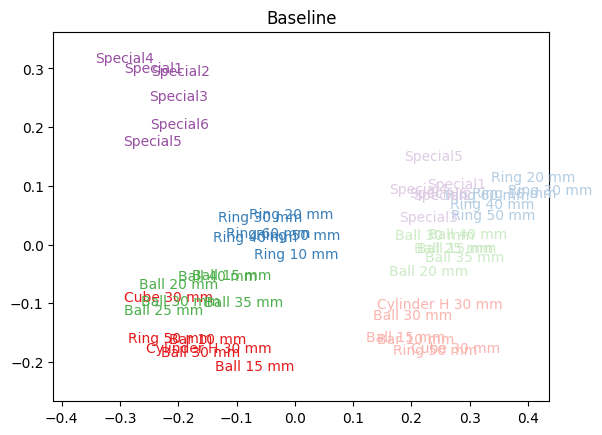

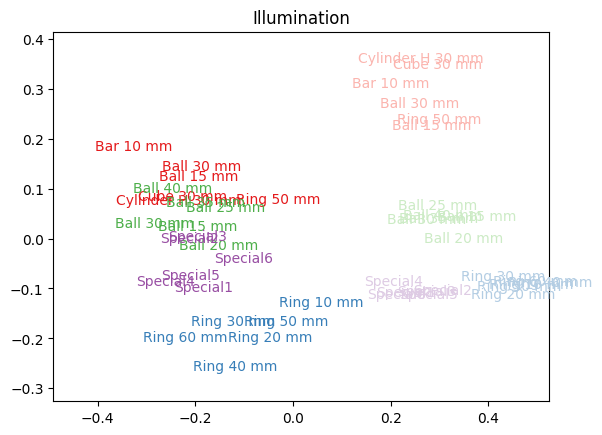

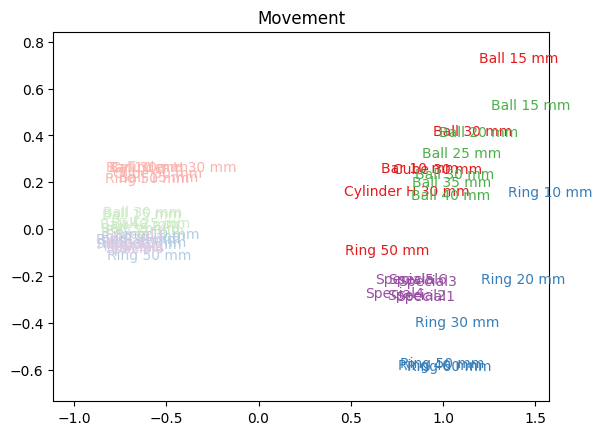

In [6]:
# make plots
df_list = [df_fixation,df_vision,df_movement]
align_names = ['Baseline','Illumination','Movement']

for idx,df_ in enumerate(df_list):
    index_levels      = df_.index.to_list()
    unique_turntables = df_.index.unique(1).to_list()

    marker_color_indices = np.array([unique_turntables.index(x[1]) for x in index_levels])

    context_names = df_fixation.index.unique(0).to_list()
    marker_colormap_indices = np.array([context_names.index(x[0]) for x in index_levels])

    cmaps = [cm.Set1,cm.Pastel1]
    
    # PCA model
    pcmdl = PCA(n_components=2)
    pcmdl.fit(df_.to_numpy())
    xt    = pcmdl.transform(df_.to_numpy()) # "X transformed" where "X" is just a general name for a data matrix

    marker_x_positions = xt[:,0]
    marker_y_positions = xt[:,1]

    xl = [min(marker_x_positions),max(marker_x_positions)]
    delx = xl[1]-xl[0]
    xl[0] = xl[0]-0.1*delx
    xl[1] = xl[1]+0.1*delx

    yl = [min(marker_y_positions),max(marker_y_positions)]
    dely = yl[1]-yl[0]
    yl[0] = yl[0]-0.1*dely
    yl[1] = yl[1]+0.1*dely

    plt.figure()
    for contextind in range(len(context_names)):
        mx = marker_x_positions[marker_colormap_indices==contextind]
        my = marker_y_positions[marker_colormap_indices==contextind]
        mc = marker_color_indices[marker_colormap_indices==contextind]
        objnames = [x[2] for x in index_levels if x[0]==context_names[contextind]]

        for objind in range(len(objnames)):
            plt.text(x=mx[objind],
                     y=my[objind],
                     s=objnames[objind],
                     color=cmaps[contextind].colors[mc[objind]])

    plt.xlim(xl)
    plt.ylim(yl)
    plt.title(align_names[idx])
    # plt.axis('off')
    plt.show()
    

# First, we need to remove any context & object information in the baseline

In [7]:
# iterate removal of axes until cross-classification performance is within one standard error of chance
# trial-based dataframes
df_fixation_trials = df[(df['alignment']=='fixation') & (df['time']<0)].groupby(['context','turntable','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
df_vision_trials   = df[(df['alignment']=='cue onset') & (df['time']>0)].groupby(['context','turntable','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
df_movement_trials = df[(df['alignment']=='hold onset') & (df['time']<0)].groupby(['context','turntable','trial'])[dp.get('neuronColumnNames')].aggregate('mean')

# pick training & test epochs
df_train = df_fixation_trials
df_test  = df_movement_trials

flag          = False
removeSpace   = None
trainset      = dict()
testset       = dict()
trainset['X'] = df_train.to_numpy()
testset['X']  = df_test.to_numpy()

# these two actually aren't any different...
trainset['y'] = np.array( [f'{df_train.index.get_level_values(0)[idx]} {df_train.index.get_level_values(1)[idx]}' for idx in range(len(df_train))] )
testset['y']  = np.array( [f'{df_test.index.get_level_values(0)[idx]} {df_test.index.get_level_values(1)[idx]}' for idx in range(len(df_test))] )

neurcount     = df_train.shape[1]
pccount       = 30

# okay let's not make it too complicated
# just fit an LDA model
# interpose a PCA model to make sure the data are well-conditioned
# exclude the axis that separates the epoch means, too, such that the LDA classifier has the best chance of generalizing across epochs

# iterate until classification is subthreshold
stopme = False
ncomps_to_remove = 0
maxcomps_to_remove = min( len( df_train.groupby(level=[0,1]).count().index ) - 1,pccount ) # number of classes minus 1, OR pccount
while not stopme:
    # do kfold cross-validation, too
    # otherwise you're using the same trial in both sets, which we know can lead to weird effects
    # all the by-trial dataframes are lined up by trial, we know this much
    skf = StratifiedKFold()
    correct_count = 0
    prior_count   = 0
    for train_,test_ in skf.split(trainset['X'],trainset['y']):
        mean_separator = np.mean(trainset['X'][train_,:],axis=0) - np.mean(testset['X'][train_,:],axis=0)
        mean_nullspace = null_space(np.matrix(mean_separator))

        PCAmdl = PCA(n_components=pccount)
        trainX_transformed = PCAmdl.fit_transform(trainset['X'][train_,:] @ mean_nullspace)
        
        # now find the appropriate nullspace for the between-class principal axes (could pre-compute these since shuffle=False... but something tells me this ain't no bottleneck)
        BCmat = df_train.iloc[train_].groupby(level=[0,1]).aggregate('mean').to_numpy()
        BCmat_transformed = PCAmdl.transform(BCmat @ mean_nullspace)
        BCPC  = PCA()
        BCPC.fit(BCmat_transformed)
        
        # now find the appropriate nullspace for the between-class principal axes
        if ncomps_to_remove > 0:
            BCnull = null_space(np.matrix(BCPC.components_[:ncomps_to_remove,:]))
        else:
            BCnull = np.eye(pccount)
        
        # apply this nullspace transformation
        trainX_transformed = trainX_transformed @ BCnull
        
        # now classify!
        LDAmdl = LDA()
        LDAmdl.fit(trainX_transformed,trainset['y'][train_])

        testX_transformed = PCAmdl.transform(testset['X'][test_,:] @ mean_nullspace)
        testX_transformed = testX_transformed @ BCnull

        yhat = LDAmdl.predict(testX_transformed)
        y    = testset['y'][test_]

        correct_count += np.sum([yhat[idx]==y[idx] for idx in range(len(y))])
        prior_count   += max(LDAmdl.priors_) * len(y)
    
    acc       = correct_count / len(testset['y'])
    chance    = prior_count / len(testset['y'])
    chancese  = np.sqrt(chance*(1-chance)/len(testset['y']))
    threshold = chance + chancese
    
    print(f"Removed Components = {ncomps_to_remove}")
    print(f"Cross-Classification Accuracy = {acc}")
    print(f"Chance Accuracy = {chance}")
    print(f"Threshold = {threshold}")
    print() # janky newline formatting
    
    if (acc > threshold) and (ncomps_to_remove < maxcomps_to_remove):
        ncomps_to_remove+=1
    else:
        stopme = True

Removed Components = 0
Cross-Classification Accuracy = 0.594758064516129
Chance Accuracy = 0.16330855479307582
Threshold = 0.1799061930046578

Removed Components = 1
Cross-Classification Accuracy = 0.39919354838709675
Chance Accuracy = 0.16330855479307582
Threshold = 0.1799061930046578

Removed Components = 2
Cross-Classification Accuracy = 0.32056451612903225
Chance Accuracy = 0.16330855479307582
Threshold = 0.1799061930046578

Removed Components = 3
Cross-Classification Accuracy = 0.22782258064516128
Chance Accuracy = 0.16330855479307582
Threshold = 0.1799061930046578

Removed Components = 4
Cross-Classification Accuracy = 0.17943548387096775
Chance Accuracy = 0.16330855479307582
Threshold = 0.1799061930046578



In [8]:
# copy-paste instead of doing any real method building
# look for object decoding and cross-classification during the movement task

# pool the contexts: 
# in principle, a proper object vision space should be the same whether the upcoming task is active vs. passive
# to the extent it ain't, well, that's probably movement preparation
# (or attentional modulation but shhhhh)
df_fixation_trials = df[(df['alignment']=='fixation') & (df['time']<0)].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
df_vision_trials   = df[(df['alignment']=='cue onset') & (df['time']>0)].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
df_movement_trials = df[(df['alignment']=='hold onset') & (df['time']<0)].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')

# pick training & test epochs
df_train = df_vision_trials
df_test  = df_movement_trials

flag          = False
removeSpace   = None
trainset      = dict()
testset       = dict()
trainset['X'] = df_train.to_numpy()
testset['X']  = df_test.to_numpy()

# these two actually aren't any different...
# note: this differs from the context x turntable baseline effect - we can just get the info from one level instead of having to pool across two!
trainset['y'] = df_train.index.get_level_values(0)
testset['y']  = df_test.index.get_level_values(0)

neurcount     = df_train.shape[1]
pccount       = 30

# okay let's not make it too complicated
# just fit an LDA model
# interpose a PCA model to make sure the data are well-conditioned
# exclude the axis that separates the epoch means, too, such that the LDA classifier has the best chance of generalizing across epochs

# iterate until classification is subthreshold
stopme = False
ncomps_to_remove = 0
maxcomps_to_remove = min( len( df_train.groupby(level=[0,1]).count().index ) - 1,pccount ) # number of classes minus 1, OR pccount
while not stopme:
    # do kfold cross-validation, too
    # otherwise you're using the same trial in both sets, which we know can lead to weird effects
    # all the by-trial dataframes are lined up by trial, we know this much
    skf = StratifiedKFold()
    correct_count = 0
    prior_count   = 0
    for train_,test_ in skf.split(trainset['X'],trainset['y']):
        mean_separator = np.mean(trainset['X'][train_,:],axis=0) - np.mean(testset['X'][train_,:],axis=0)
        mean_nullspace = null_space(np.matrix(mean_separator))

        PCAmdl = PCA(n_components=pccount)
        trainX_transformed = PCAmdl.fit_transform(trainset['X'][train_,:] @ mean_nullspace)
        
        # now find the appropriate nullspace for the between-class principal axes (could pre-compute these since shuffle=False... but something tells me this ain't no bottleneck)
        BCmat = df_train.iloc[train_].groupby(level=[0,1]).aggregate('mean').to_numpy()
        BCmat_transformed = PCAmdl.transform(BCmat @ mean_nullspace)
        BCPC  = PCA()
        BCPC.fit(BCmat_transformed)
        
        # now find the appropriate nullspace for the between-class principal axes
        if ncomps_to_remove > 0:
            BCnull = null_space(np.matrix(BCPC.components_[:ncomps_to_remove,:]))
        else:
            BCnull = np.eye(pccount)
        
        # apply this nullspace transformation
        trainX_transformed = trainX_transformed @ BCnull
        
        # now classify!
        LDAmdl = LDA()
        LDAmdl.fit(trainX_transformed,trainset['y'][train_])

        testX_transformed = PCAmdl.transform(testset['X'][test_,:] @ mean_nullspace)
        testX_transformed = testX_transformed @ BCnull

        yhat = LDAmdl.predict(testX_transformed)
        y    = testset['y'][test_]

        correct_count += np.sum([yhat[idx]==y[idx] for idx in range(len(y))])
        prior_count   += max(LDAmdl.priors_) * len(y)
    
    acc       = correct_count / len(testset['y'])
    chance    = prior_count / len(testset['y'])
    chancese  = np.sqrt(chance*(1-chance)/len(testset['y']))
    threshold = chance + chancese
    
    print(f"Removed Components = {ncomps_to_remove}")
    print(f"Cross-Classification Accuracy = {acc}")
    print(f"Chance Accuracy = {chance}")
    print(f"Threshold = {threshold}")
    print() # janky newline formatting
    
    if (acc > threshold) and (ncomps_to_remove < maxcomps_to_remove):
        ncomps_to_remove+=1
    else:
        stopme = True

Removed Components = 0
Cross-Classification Accuracy = 0.12298387096774194
Chance Accuracy = 0.08064557166694161
Threshold = 0.09287175518355723

Removed Components = 1
Cross-Classification Accuracy = 0.11290322580645161
Chance Accuracy = 0.08064557166694161
Threshold = 0.09287175518355723

Removed Components = 2
Cross-Classification Accuracy = 0.11088709677419355
Chance Accuracy = 0.08064557166694161
Threshold = 0.09287175518355723

Removed Components = 3
Cross-Classification Accuracy = 0.10483870967741936
Chance Accuracy = 0.08064557166694161
Threshold = 0.09287175518355723

Removed Components = 4
Cross-Classification Accuracy = 0.09475806451612903
Chance Accuracy = 0.08064557166694161
Threshold = 0.09287175518355723

Removed Components = 5
Cross-Classification Accuracy = 0.09879032258064516
Chance Accuracy = 0.08064557166694161
Threshold = 0.09287175518355723

Removed Components = 6
Cross-Classification Accuracy = 0.0907258064516129
Chance Accuracy = 0.08064557166694161
Threshold = 

# Movement period decoding before & after vision-removal

In [17]:
df_vision_trials   = df[(df['alignment']=='cue onset') & (df['time']>0) & (df['context']=='active')].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
df_movement_trials = df[(df['alignment']=='hold onset') & (df['time']<0) & (df['context']=='active')].groupby(['grip','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
# todo: get this to work outside a context-specific setting
# todo: resample neurons to equalize sample sizes across cortical areas

# pick training & test epochs
df_train = df_vision_trials
df_test  = df_movement_trials

flag          = False
removeSpace   = None
trainset      = dict()
testset       = dict()
trainset['X'] = df_train.to_numpy()
testset['X']  = df_test.to_numpy()

# these two actually aren't any different...
# note: this differs from the context x turntable baseline effect - we can just get the info from one level instead of having to pool across two!
trainset['y'] = df_train.index.get_level_values(0)
testset['y']  = df_test.index.get_level_values(0)

neurcount     = df_train.shape[1]
pccount       = 30

# okay let's not make it too complicated
# just fit an LDA model
# interpose a PCA model to make sure the data are well-conditioned
# exclude the axis that separates the epoch means, too, such that the LDA classifier has the best chance of generalizing across epochs

skf = StratifiedKFold()
correct_count_raw  = 0
correct_count_proc = 0
prior_count   = 0
for train_,test_ in skf.split(trainset['X'],trainset['y']):
    mean_separator = np.mean(trainset['X'][train_,:],axis=0) - np.mean(testset['X'][train_,:],axis=0)
    mean_nullspace = null_space(np.matrix(mean_separator))

    PCAmdl = PCA(n_components=pccount)
    PCAmdl.fit(trainset['X'][train_,:] @ mean_nullspace)

    # now find the appropriate nullspace for the between-class principal axes (could pre-compute these since shuffle=False... but something tells me this ain't no bottleneck)
    BCmat = df_train.iloc[train_].groupby(level=[0,1]).aggregate('mean').to_numpy()
    BCmat_transformed = PCAmdl.transform(BCmat @ mean_nullspace)
    BCPC  = PCA()
    BCPC.fit(BCmat_transformed)
        
    # so basically, the space we want to compute the null w.r.t. is:
    # delta_mean_vector x (delta_mean_nullspace @ PCs @ aggPCs)
    # delta_mean_vector: nneur x 1
    # aggPCs: npcs x nremove
    # PCs: (nneur-1) x npcs
    # delta_mean_nullspace: nneur x (nneur-1)
    # (note: originally, there was a centering operation between each projection onto a PC space)
    # (with that said, the centering before aggPCs should have been minimal)
    # (and in any case, the omission of that centering will simply result in a translated neural manifold)
    # (which in turn does not affect LDA!)
    grand_null = null_space( np.vstack((mean_separator,
                                       BCPC.components_[:ncomps_to_remove,:] @ PCAmdl.components_ @ mean_nullspace.T)) )
    
    # now classify
    PCA_raw  = PCA(n_components=pccount)
    PCA_proc = PCA(n_components=pccount)
    
    trainXraw  = PCA_raw.fit_transform(testset['X'][train_,:])
    trainXproc = PCA_proc.fit_transform(testset['X'][train_,:] @ grand_null)

    # now classify!
    LDAraw  = LDA()
    LDAproc = LDA()
    
    LDAraw.fit(trainXraw,testset['y'][train_])
    LDAproc.fit(trainXproc,testset['y'][train_])
    
    testXraw  = PCA_raw.transform(testset['X'][test_,:])
    testXproc = PCA_proc.transform(testset['X'][test_,:] @ grand_null)

    yhatraw  = LDAraw.predict(testXraw)
    yhatproc = LDAproc.predict(testXproc)
    y        = testset['y'][test_]

    correct_count_raw += np.sum([yhatraw[idx]==y[idx] for idx in range(len(y))])
    correct_count_proc += np.sum([yhatproc[idx]==y[idx] for idx in range(len(y))])
    prior_count   += max(LDAraw.priors_) * len(y) # same for both models

accraw    = correct_count_raw / len(testset['y'])
accproc   = correct_count_proc / len(testset['y'])
chance    = prior_count / len(testset['y'])
chancese  = np.sqrt(chance*(1-chance)/len(testset['y']))
threshold = chance + chancese

print(f"Raw Classification Accuracy = {accraw}")
print(f"Removed Components = {ncomps_to_remove}")
print(f"Post-Removal Classification Accuracy = {accproc}")
print(f"Chance Accuracy = {chance}")
print(f"Threshold = {threshold}")

Raw Classification Accuracy = 0.8062015503875969
Removed Components = 6
Post-Removal Classification Accuracy = 0.7984496124031008
Chance Accuracy = 0.31390604088337404
Threshold = 0.3427983186518769


In [14]:
neurcount

99

# Whoopsie
Seems like your new, more lenient orthogonalization routine finds some pretty substantial mirror-like activity... especially in F5 of Zara64?!?!?!?

Which is in the right? Old or new???

ughhhhhhh I don't need this I need to make a POSTER!!!!!

# Forget about the baseline
1. For some datasets it doesn't cross-classify well with the movement period anyway
2. To the extent it does, removing the visual space should get rid of most of the effect anyway
3. To the extent it doesn't, the main effect will be a mean separation across the tasks, which you'll remove anyway

# Here be controls:
1. Special turntable stops being decoded during movement
2. grasping box keeps being decoded during movement
3. "control" task performance during movement is less affected than "active" task

# Mirror neuron seek
1. Two axes: visuomotor and active-passive
2. The idea: the two should be correlated, but mirror neurons should exist along an "offset" trendline (i.e., one where the active-passive index is shifted w.r.t. the "normal" neurons along the visuomotor gradient)